# Motion Prior Example

In [1]:
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt

%matplotlib inline
%matplotlib widget
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Times"],
        "font.size": 14,
    }
)

np.set_printoptions(6, suppress=True)
np.random.seed(0)

from pylgmath import se3op, Transformation
from pysteam.evaluable import se3 as se3ev, vspace as vspaceev
from pysteam.evaluable.vspace import VSpaceStateVar
from pysteam import problem, solver, trajectory


def plot_trajectory(ax, timestamp, T_mr, w_mr_inr, label=None):
    # pose
    T_mr_vec = np.array([_.vec() for _ in T_mr]).squeeze()
    ax[0, 0].plot(timestamp, T_mr_vec[:, 0], label=label)
    ax[0, 1].plot(timestamp, T_mr_vec[:, 1], label=label)
    ax[0, 2].plot(timestamp, T_mr_vec[:, 2], label=label)
    ax[0, 3].plot(timestamp, T_mr_vec[:, 3], label=label)
    ax[0, 4].plot(timestamp, T_mr_vec[:, 4], label=label)
    ax[0, 5].plot(timestamp, T_mr_vec[:, 5], label=label)
    legend = ["x [m]", "y [m]", "z [m]", "roll [rad]", "pitch [rad]", "yaw [rad]"]
    for i in range(6):
        ax[0, i].set_xlabel("time [s]")
        ax[0, i].set_ylabel(legend[i])
        ax[0, i].set_ylim([-2.0, 2.0])
        ax[0, i].legend()

    # velocity
    w_mr_inr = np.array(w_mr_inr).squeeze()
    ax[1, 0].plot(timestamp, w_mr_inr[:, 0], label=label)
    ax[1, 1].plot(timestamp, w_mr_inr[:, 1], label=label)
    ax[1, 2].plot(timestamp, w_mr_inr[:, 2], label=label)
    ax[1, 3].plot(timestamp, w_mr_inr[:, 3], label=label)
    ax[1, 4].plot(timestamp, w_mr_inr[:, 4], label=label)
    ax[1, 5].plot(timestamp, w_mr_inr[:, 5], label=label)
    legend = [
        "x [m/s]",
        "y [m/s]",
        "z [m/s]",
        "roll [rad/s]",
        "pitch [rad/s]",
        "yaw [rad/s]",
    ]
    for i in range(6):
        ax[1, i].set_xlabel("time [s]")
        ax[1, i].set_ylabel(legend[i])
        ax[1, i].set_ylim([-2.0, 2.0])
        ax[1, i].legend()


# Configuration
KNOT_TIMES = np.linspace(0, 1, 11)
MEAS_TIMES = np.linspace(0, 1, 5)
PLOT_TIMES = np.linspace(0, 1, 101)

## White Noise on Acceleration Prior

Begin Optimization
------------------
Number of States:  22
Number of Cost Terms:  17
Initial Cost:  2.6503409938500884
Iteration:    1  -  Cost:     0.8677
Iteration:    2  -  Cost:     0.8417
Iteration:    3  -  Cost:     0.8417
Termination Cause:  CONVERGED ABSOLUTE CHANGE


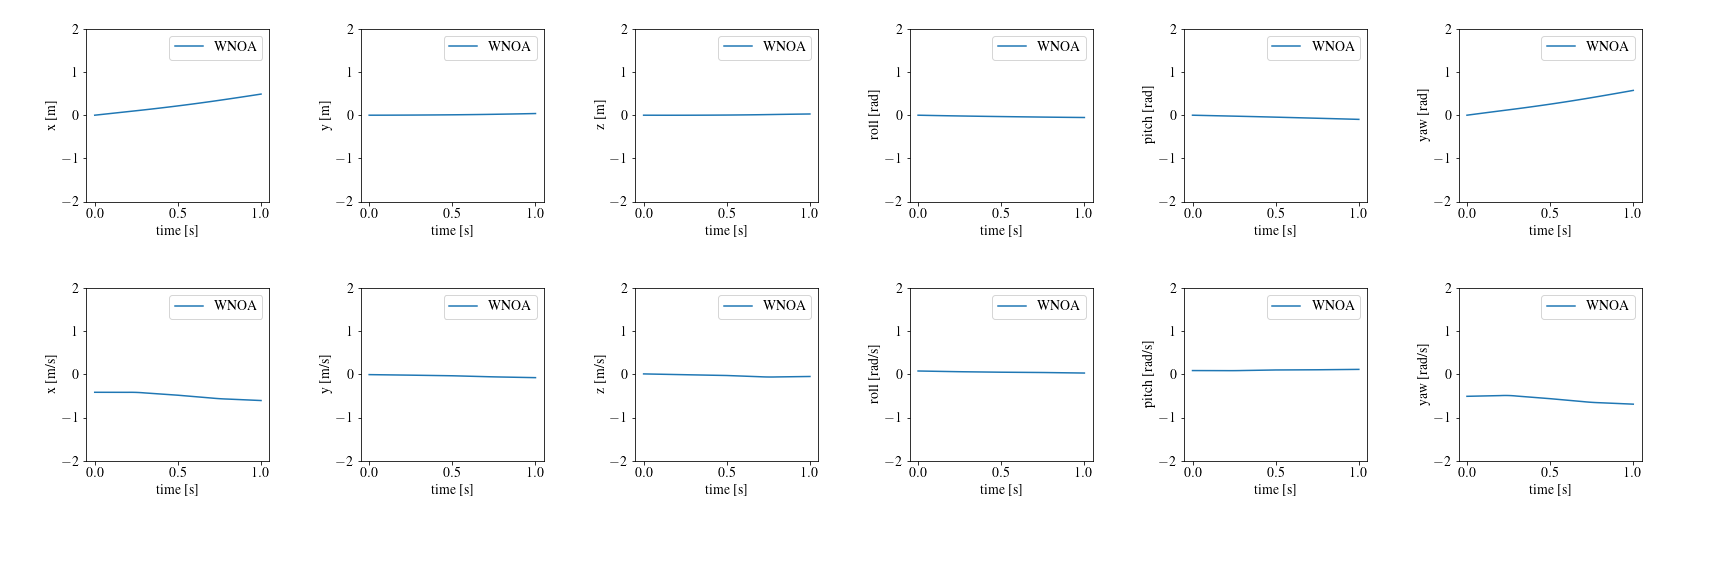

In [2]:
## instantiate trajectory
qcd = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])  # Qc diagonal
traj = trajectory.const_vel.Interface(qcd=qcd)

## add knots
T_rm_vars = []
w_mr_inr_vars = []
for t in KNOT_TIMES:
    T_rm_vars.append(se3ev.SE3StateVar(Transformation(xi_ab=np.zeros((6, 1)))))
    w_mr_inr_vars.append(vspaceev.VSpaceStateVar(np.zeros((6, 1))))
    traj.add_knot(
        time=trajectory.Time(secs=t), T_k0=T_rm_vars[-1], w_0k_ink=w_mr_inr_vars[-1]
    )

## prior on initial time
time_prior = trajectory.Time(secs=KNOT_TIMES[0])
T_rm_prior = Transformation(xi_ab=np.zeros((6, 1)))
w_mr_inr_prior = np.array(
    [[-1.0, 0.0, 0.0, 0.0, 0.0, -1.0]]
).T  # prior has non-zero velocity
traj.add_pose_prior(time_prior, T_rm_prior, np.eye(6))
traj.add_velocity_prior(time_prior, w_mr_inr_prior, np.eye(6))

## measurements cost terms
meas_terms = []
for t in MEAS_TIMES:
    w_mr_inr_meas = w_mr_inr_prior * t + np.random.normal(0, 0.1, (6, 1))
    # print('t=', t, 'w_mr_inr_meas=', w_mr_inr_meas.flatten())
    time = trajectory.Time(secs=t)
    w_mr_inr_eval = traj.get_velocity_interpolator(time)
    error_func = vspaceev.vspace_error(w_mr_inr_eval, w_mr_inr_meas)
    loss_func = problem.L2LossFunc()
    noise_model = problem.StaticNoiseModel(np.eye(6), "covariance")
    meas_terms.append(
        problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    )

## Make optimization problem
opt_prob = problem.OptimizationProblem()
opt_prob.add_state_var(*T_rm_vars, *w_mr_inr_vars)
opt_prob.add_cost_term(*traj.get_prior_cost_terms(), *meas_terms)

## Make solver and solve
optimizer = solver.GaussNewtonSolver(opt_prob, verbose=True)
optimizer.optimize()

## plot
timestamps_plot = PLOT_TIMES
T_mr_plot = []
w_mr_inr_plot = []
for i in timestamps_plot:
    time = trajectory.Time(secs=i)
    T_mr_plot.append(se3ev.inv(traj.get_pose_interpolator(time)).evaluate())
    w_mr_inr_plot.append(traj.get_velocity_interpolator(time).evaluate())

fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)
plot_trajectory(
    ax, timestamp=timestamps_plot, T_mr=T_mr_plot, w_mr_inr=w_mr_inr_plot, label="WNOA"
)
plt.show()

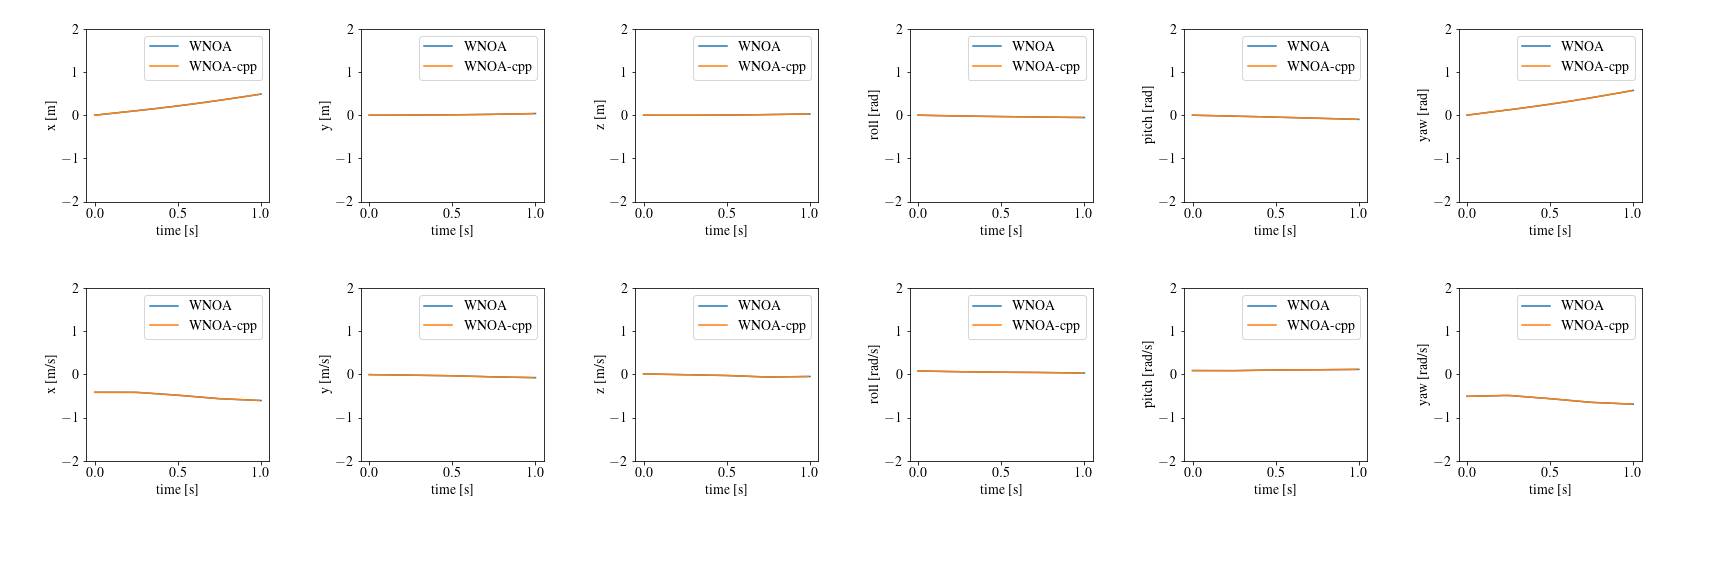

In [3]:
filename = "/ext0/ASRL/steam_dev/temp/wnoa.txt"
cpp_result = np.loadtxt(filename)
timestamps_cpp = cpp_result[:, 0]
T_mr_cpp = [Transformation(xi_ab=xi_ab[..., None]) for xi_ab in cpp_result[:, 1:7]]
w_mr_inr_cpp = cpp_result[:, 7:]

fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)
plot_trajectory(
    ax, timestamp=timestamps_plot, T_mr=T_mr_plot, w_mr_inr=w_mr_inr_plot, label="WNOA"
)
plot_trajectory(
    ax, timestamp=timestamps_cpp, T_mr=T_mr_cpp, w_mr_inr=w_mr_inr_cpp, label="WNOA-cpp"
)
plt.show()

## White Noise on Jerk Prior

Begin Optimization
------------------
Number of States:  33
Number of Cost Terms:  18
Initial Cost:  1.133769083113158
Iteration:    1  -  Cost:   166.4671
Iteration:    2  -  Cost:     0.4213
Iteration:    3  -  Cost:     0.4212
Termination Cause:  CONVERGED ABSOLUTE CHANGE


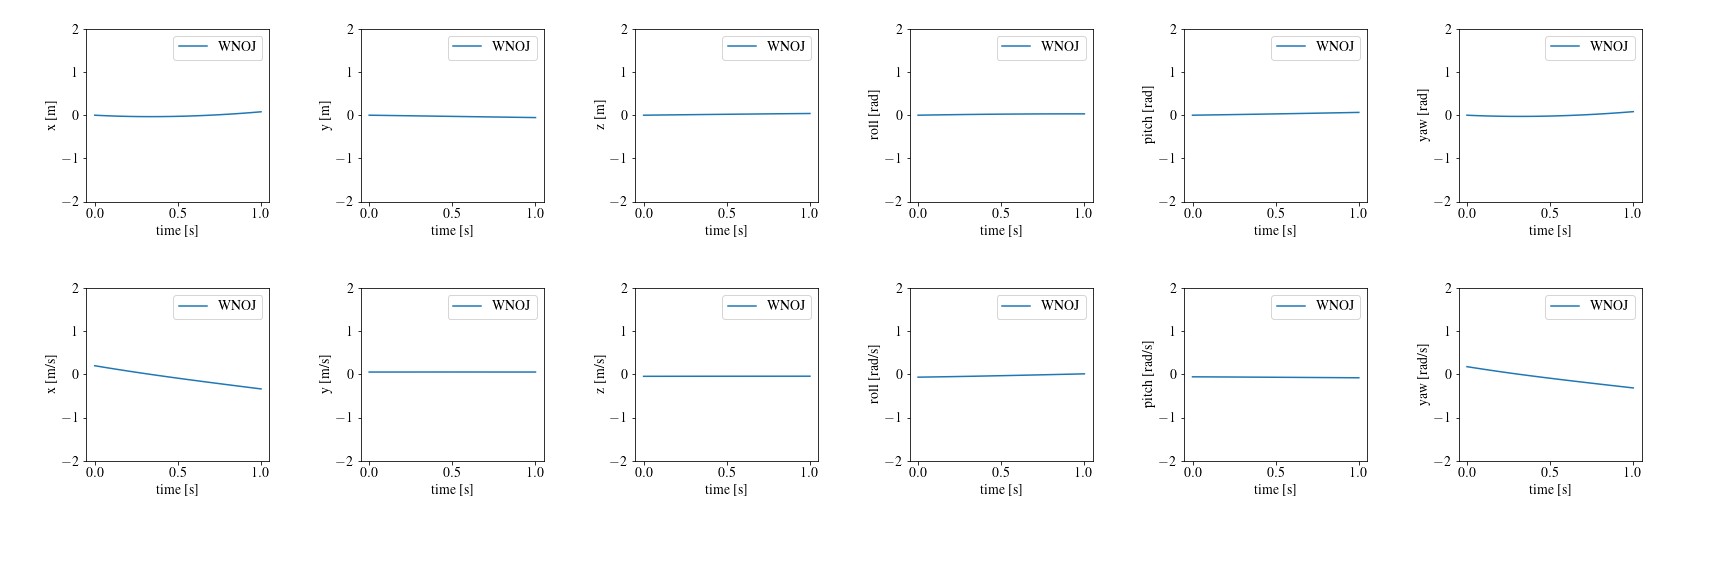

In [4]:
## Setup trajectory
qcd = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
traj = trajectory.const_acc.Interface(qcd=qcd)

T_rm_vars = []
w_mr_inr_vars = []
dw_mr_inr_vars = []
for t in KNOT_TIMES:
    T_rm_vars.append(se3ev.SE3StateVar(Transformation(xi_ab=np.zeros((6, 1)))))
    w_mr_inr_vars.append(vspaceev.VSpaceStateVar(np.zeros((6, 1))))
    dw_mr_inr_vars.append(vspaceev.VSpaceStateVar(np.zeros((6, 1))))
    traj.add_knot(
        time=trajectory.Time(secs=t),
        T_k0=T_rm_vars[-1],
        w_0k_ink=w_mr_inr_vars[-1],
        dw_0k_ink=dw_mr_inr_vars[-1],
    )

## prior on initial time
time_prior = trajectory.Time(secs=KNOT_TIMES[0])
T_rm_prior = Transformation(xi_ab=np.zeros((6, 1)))
w_mr_inr_prior = np.zeros((6, 1))
dw_mr_inr_prior = np.array(
    [[-1.0, 0.0, 0.0, 0.0, 0.0, -1.0]]
).T  # prior has non-zero acceleration
traj.add_pose_prior(time_prior, T_rm_prior, np.eye(6))
traj.add_velocity_prior(time_prior, w_mr_inr_prior, np.eye(6))
traj.add_acceleration_prior(time_prior, dw_mr_inr_prior, np.eye(6))

## measurements cost terms
meas_terms = []
for t in MEAS_TIMES:
    w_mr_inr_meas = w_mr_inr_prior * t + np.random.normal(0, 0.1, (6, 1))
    # print('t=', t, 'w_mr_inr_meas=', w_mr_inr_meas.flatten())
    time = trajectory.Time(secs=t)
    w_mr_inr_eval = traj.get_velocity_interpolator(time)
    error_func = vspaceev.vspace_error(w_mr_inr_eval, w_mr_inr_meas)
    loss_func = problem.L2LossFunc()
    noise_model = problem.StaticNoiseModel(np.eye(6), "covariance")
    meas_terms.append(
        problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    )

## Make optimization problem
opt_prob = problem.OptimizationProblem()
opt_prob.add_state_var(*T_rm_vars, *w_mr_inr_vars, *dw_mr_inr_vars)
opt_prob.add_cost_term(*traj.get_prior_cost_terms(), *meas_terms)

## Make solver and solve
optimizer = solver.GaussNewtonSolver(opt_prob, verbose=True)
optimizer.optimize()

## plot
timestamps_plot = PLOT_TIMES
T_mr_plot = []
w_mr_inr_plot = []
for i in timestamps_plot:
    time = trajectory.Time(secs=i)
    T_mr_plot.append(se3ev.inv(traj.get_pose_interpolator(time)).evaluate())
    w_mr_inr_plot.append(traj.get_velocity_interpolator(time).evaluate())

fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)
plot_trajectory(
    ax, timestamp=timestamps_plot, T_mr=T_mr_plot, w_mr_inr=w_mr_inr_plot, label="WNOJ"
)
plt.show()

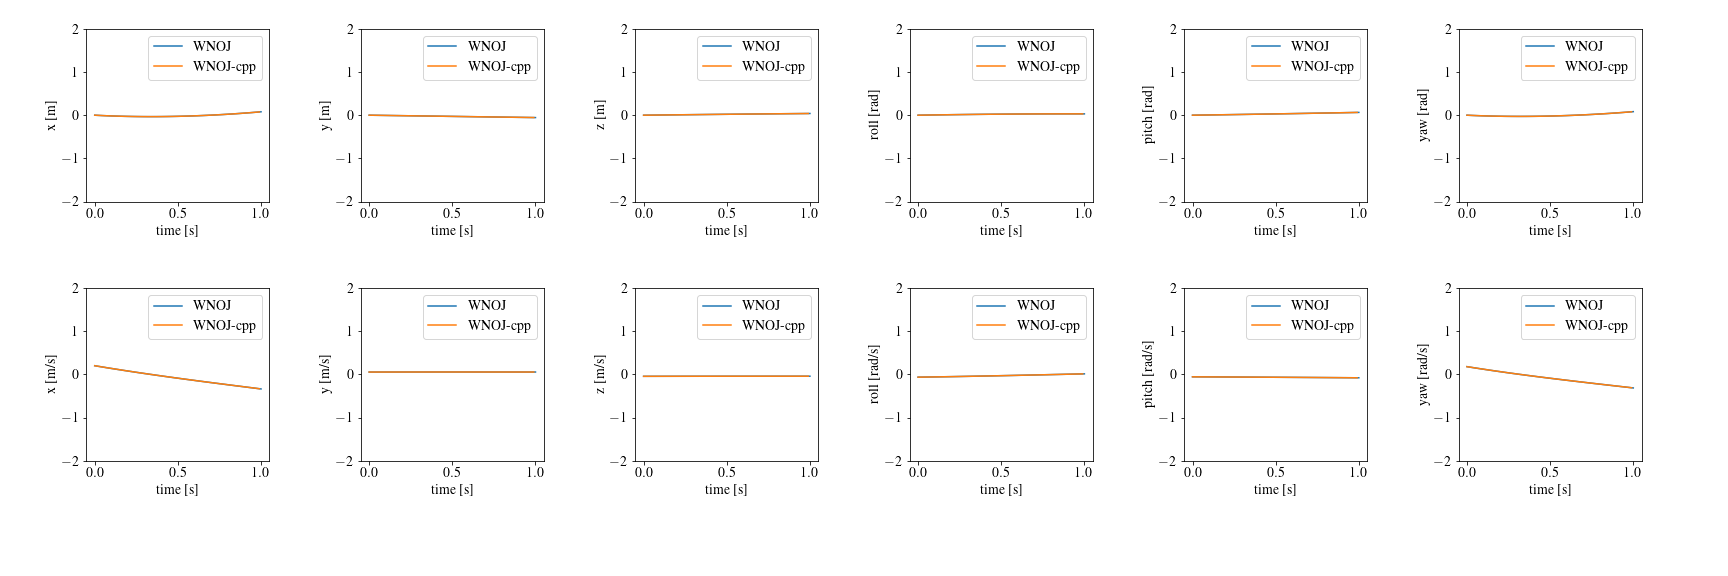

In [5]:
filename = "/ext0/ASRL/steam_dev/temp/wnoj.txt"
cpp_result = np.loadtxt(filename)
timestamps_cpp = cpp_result[:, 0]
T_mr_cpp = [Transformation(xi_ab=xi_ab[..., None]) for xi_ab in cpp_result[:, 1:7]]
w_mr_inr_cpp = cpp_result[:, 7:]

fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)
plot_trajectory(
    ax, timestamp=timestamps_plot, T_mr=T_mr_plot, w_mr_inr=w_mr_inr_plot, label="WNOJ"
)
plot_trajectory(
    ax, timestamp=timestamps_cpp, T_mr=T_mr_cpp, w_mr_inr=w_mr_inr_cpp, label="WNOJ-cpp"
)
plt.show()

## Singer Prior

Begin Optimization
------------------
Number of States:  33
Number of Cost Terms:  18
Initial Cost:  1.137722098717763
Iteration:    1  -  Cost:     4.0743
Iteration:    2  -  Cost:     0.3928
Iteration:    3  -  Cost:     0.3928
Termination Cause:  CONVERGED ABSOLUTE CHANGE


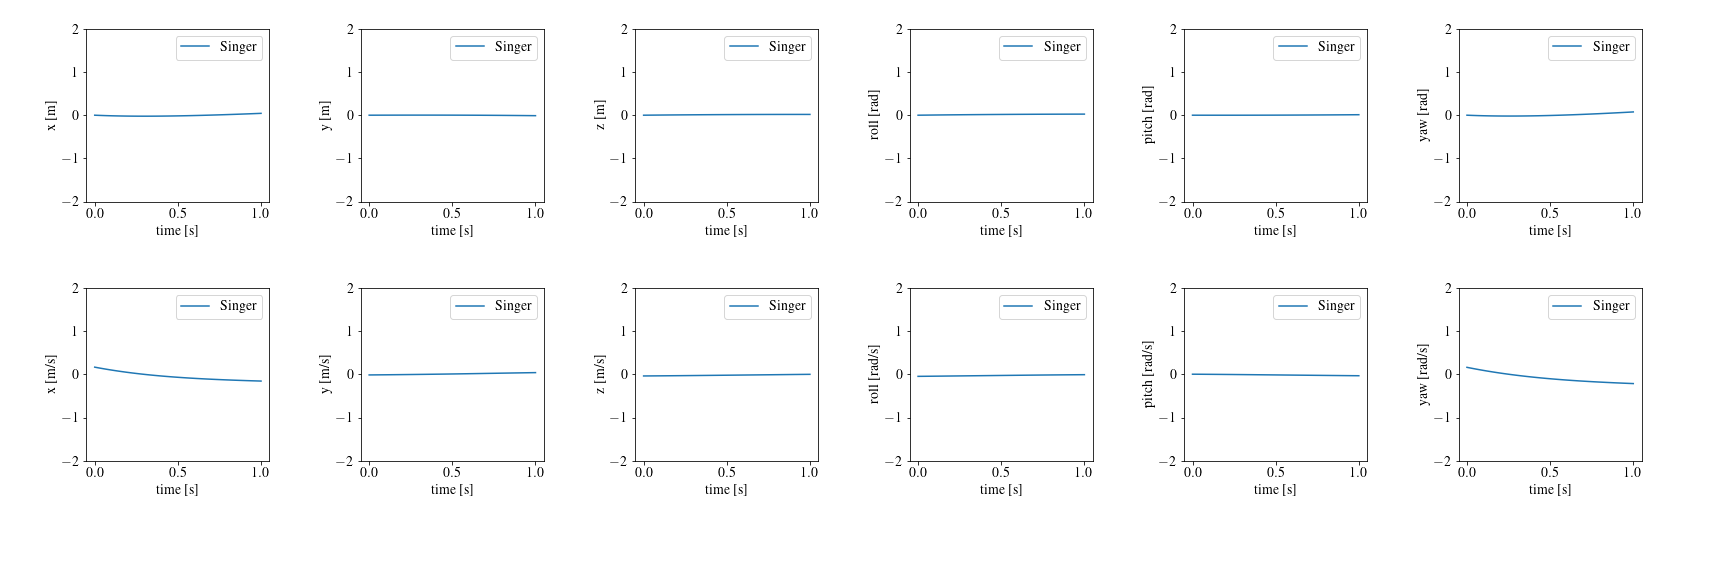

In [6]:
## Setup trajectory
ad = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
qcd = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
traj = trajectory.singer.Interface(qcd=qcd, ad=ad)

T_rm_vars = []
w_mr_inr_vars = []
dw_mr_inr_vars = []
for t in KNOT_TIMES:
    T_rm_vars.append(se3ev.SE3StateVar(Transformation(xi_ab=np.zeros((6, 1)))))
    w_mr_inr_vars.append(vspaceev.VSpaceStateVar(np.zeros((6, 1))))
    dw_mr_inr_vars.append(vspaceev.VSpaceStateVar(np.zeros((6, 1))))
    traj.add_knot(
        time=trajectory.Time(secs=t),
        T_k0=T_rm_vars[-1],
        w_0k_ink=w_mr_inr_vars[-1],
        dw_0k_ink=dw_mr_inr_vars[-1],
    )

## prior on initial time
time_prior = trajectory.Time(secs=KNOT_TIMES[0])
T_rm_prior = Transformation(xi_ab=np.zeros((6, 1)))
w_mr_inr_prior = np.zeros((6, 1))
dw_mr_inr_prior = np.array(
    [[-1.0, 0.0, 0.0, 0.0, 0.0, -1.0]]
).T  # prior has non-zero acceleration
traj.add_pose_prior(time_prior, T_rm_prior, np.eye(6))
traj.add_velocity_prior(time_prior, w_mr_inr_prior, np.eye(6))
traj.add_acceleration_prior(time_prior, dw_mr_inr_prior, np.eye(6))

## measurements cost terms
meas_terms = []
for t in MEAS_TIMES:
    w_mr_inr_meas = w_mr_inr_prior * t + np.random.normal(0, 0.1, (6, 1))
    # print('t=', t, 'w_mr_inr_meas=', w_mr_inr_meas.flatten())
    time = trajectory.Time(secs=t)
    w_mr_inr_eval = traj.get_velocity_interpolator(time)
    error_func = vspaceev.vspace_error(w_mr_inr_eval, w_mr_inr_meas)
    loss_func = problem.L2LossFunc()
    noise_model = problem.StaticNoiseModel(np.eye(6), "covariance")
    meas_terms.append(
        problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    )

## Make optimization problem
opt_prob = problem.OptimizationProblem()
opt_prob.add_state_var(*T_rm_vars, *w_mr_inr_vars, *dw_mr_inr_vars)
opt_prob.add_cost_term(*traj.get_prior_cost_terms(), *meas_terms)

## Make solver and solve
optimizer = solver.GaussNewtonSolver(opt_prob, verbose=True)
optimizer.optimize()

## plot
timestamps_plot = PLOT_TIMES
T_mr_plot = []
w_mr_inr_plot = []
for i in timestamps_plot:
    time = trajectory.Time(secs=i)
    T_mr_plot.append(se3ev.inv(traj.get_pose_interpolator(time)).evaluate())
    w_mr_inr_plot.append(traj.get_velocity_interpolator(time).evaluate())

fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)
plot_trajectory(
    ax,
    timestamp=timestamps_plot,
    T_mr=T_mr_plot,
    w_mr_inr=w_mr_inr_plot,
    label="Singer",
)
plt.show()

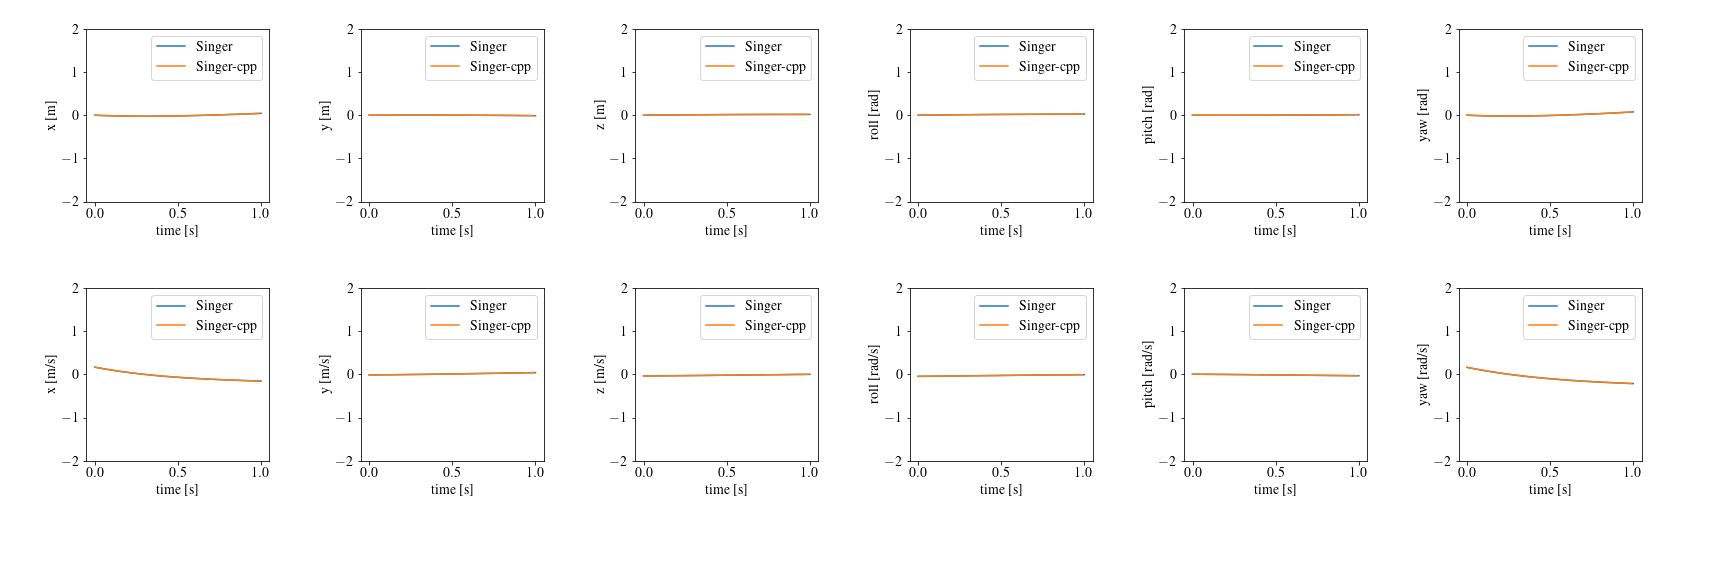

In [7]:
filename = "/ext0/ASRL/steam_dev/temp/singer.txt"
cpp_result = np.loadtxt(filename)
timestamps_cpp = cpp_result[:, 0]
T_mr_cpp = [Transformation(xi_ab=xi_ab[..., None]) for xi_ab in cpp_result[:, 1:7]]
w_mr_inr_cpp = cpp_result[:, 7:]

fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95, wspace=0.5, hspace=0.5)
plot_trajectory(
    ax,
    timestamp=timestamps_plot,
    T_mr=T_mr_plot,
    w_mr_inr=w_mr_inr_plot,
    label="Singer",
)
plot_trajectory(
    ax,
    timestamp=timestamps_cpp,
    T_mr=T_mr_cpp,
    w_mr_inr=w_mr_inr_cpp,
    label="Singer-cpp",
)
plt.show()